# Audio Tokenizer 
The goal of this notebook is to present and compare the different audio tokenization architectures we experimented with. Each approach aims to compress raw audio into a sequence of discrete tokens, ideally aligning with the granularity of text tokens to facilitate multimodal training. We evaluate the effectiveness of each tokenizer in terms of token rate, fidelity, and compatibility with language models.

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
current_folder = globals()['_dh'][0]
os.chdir(os.path.dirname(os.path.abspath(current_folder)))

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchaudio.transforms as T
from torch.utils.data import DataLoader
from pathlib import Path
from IPython.display import display, Audio
import torchaudio
from wavenet_vocoder.wavenet import WaveNet
from audio_tokenizer.vqvae.models.vqvae import VQVAE,RawVQVAE
from audio_tokenizer.vqvae.data.dataset import LibriSpeechMelDataset
from audio_tokenizer.vqvae.data.audio_utils import visualize_waveform,visualize_spectogram,stft_loss
WEIGHTS_WAVENET = "/work/com-304/snoupy/weights/wavenet/final.pt"
WEIGHTS_VQVAE = "/work/com-304/snoupy/weights/vqvae/final/adamw_epoch13.pt"
DATASET_PATH = "/work/com-304/snoupy/librispeech/"
DATASET = "dev-clean" 
SAVE_PATH = "/work/com-304/snoupy/samples"
ORIGINAL_WAV  = f"{SAVE_PATH}/original.wav" 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## VQ-VAE
### Architecture 
![vqvae-architecture](notebooks/assets/vqvae.jpg)


Waveform shape : torch.Size([1, 1, 32000]), sample rate 16000


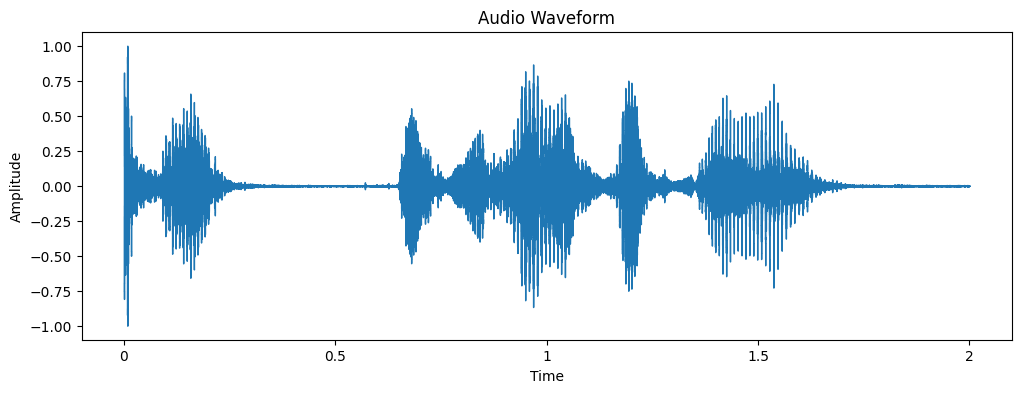

Reconstructed waveform shape : torch.Size([1, 32000]), sample rate 16000


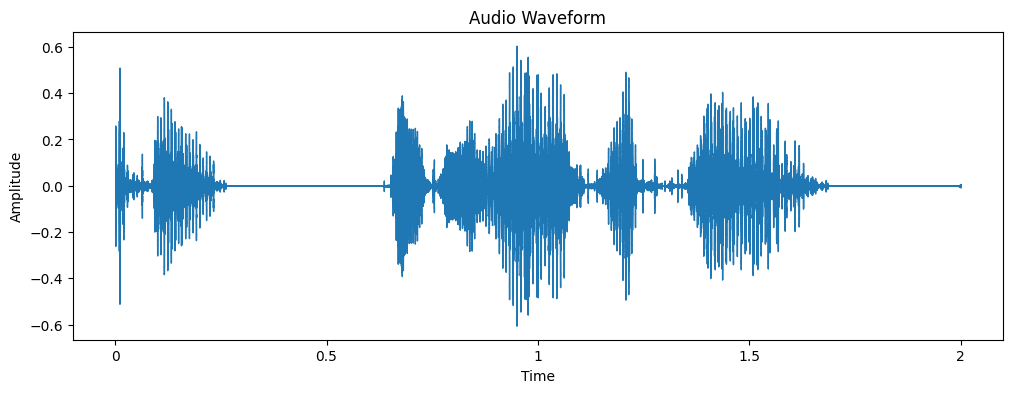

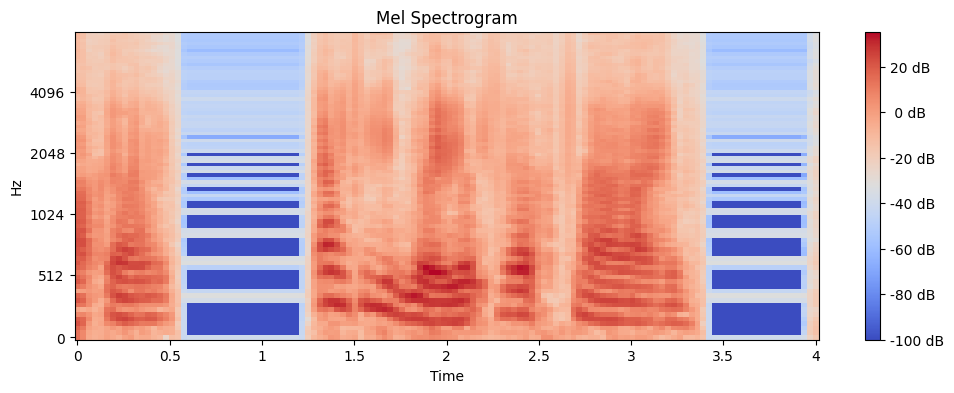

Reconstruction loss on waveform : 0.05
Reconstruction loss on spectogram : 0.55


/home/vifian/.local/lib/python3.10/site-packages/torch/functional.py:709: UserWarning: A window was not provided. A rectangular window will be applied,which is known to cause spectral leakage. Other windows such as torch.hann_window or torch.hamming_window can are recommended to reduce spectral leakage.To suppress this warning and use a rectangular window, explicitly set `window=torch.ones(n_fft, device=<device>)`. (Triggered internally at /pytorch/aten/src/ATen/native/SpectralOps.cpp:836.)
  return _VF.stft(  # type: ignore[attr-defined]


In [2]:
# === Load VQ-VAE ===
vqvae = RawVQVAE(embedding_dim=128, num_embeddings=512).to(device)
vqvae.load_state_dict(torch.load(WEIGHTS_VQVAE, weights_only=True))
vqvae.eval()

# === Load Sample === 
waveform, sr = torchaudio.load(ORIGINAL_WAV)
waveform = waveform.unsqueeze(0).to(device)

# Transform wav to mel spectogram 
mel_transform = T.MelSpectrogram(
    sample_rate=sr,
    n_fft=1024,
    hop_length=256,
    n_mels=80
)
     
# === Normalize wav ===
wf_n = waveform = waveform / waveform.abs().max(dim=-1, keepdim=True)[0].clamp(min=1e-5)

display_wf = wf_n.squeeze(0).detach().cpu()
print(f"Waveform shape : {waveform.shape}, sample rate {sr}")
visualize_waveform(display_wf,sr=sr)
display(Audio(display_wf,rate=sr))

# === Reconstruct with vqvae ===
wf_vqvae,_ = vqvae(wf_n)
wf_vqvae = wf_vqvae.squeeze(0).detach().cpu()
print(f"Reconstructed waveform shape : {wf_vqvae.shape}, sample rate {sr}")
visualize_waveform(wf_vqvae,sr=sr)
visualize_spectogram(torchaudio.transforms.AmplitudeToDB()(mel_transform(wf_vqvae)),sr=sr)
display(Audio(wf_vqvae,rate=sr))

# === Compute Loss between original and reconstruction === 
l1_loss = nn.L1Loss()
vqvae_l1 = l1_loss(wf_vqvae,display_wf)
vqvae_stft = stft_loss(wf_vqvae,display_wf)
print(f"Reconstruction loss on waveform : {vqvae_l1:.2f}")
print(f"Reconstruction loss on spectogram : {vqvae_stft:.2f}")

# VQ-VAE + Wavenet
## Architecture
![vqvae-wavenet](notebooks/assets/vqvae-wavenet.jpg)

/home/vifian/.local/lib/python3.10/site-packages/torch/nn/utils/weight_norm.py:143: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)


Reconstructed waveform shape : torch.Size([1, 32000]), sample rate 16000


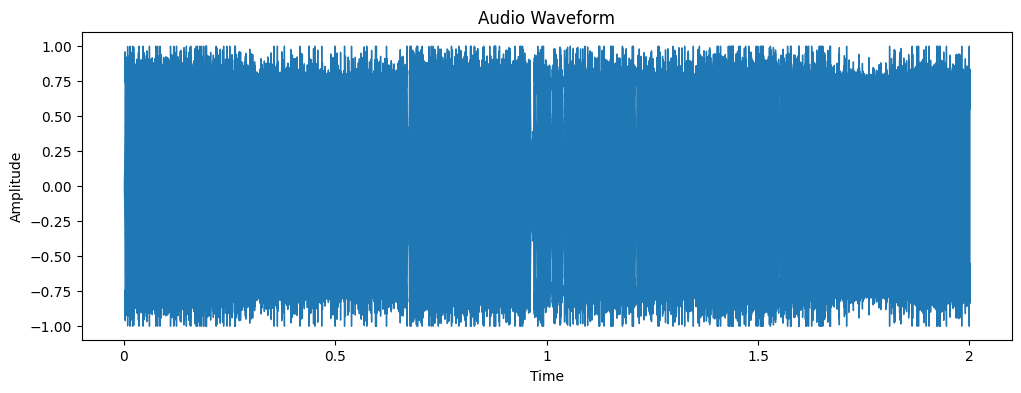

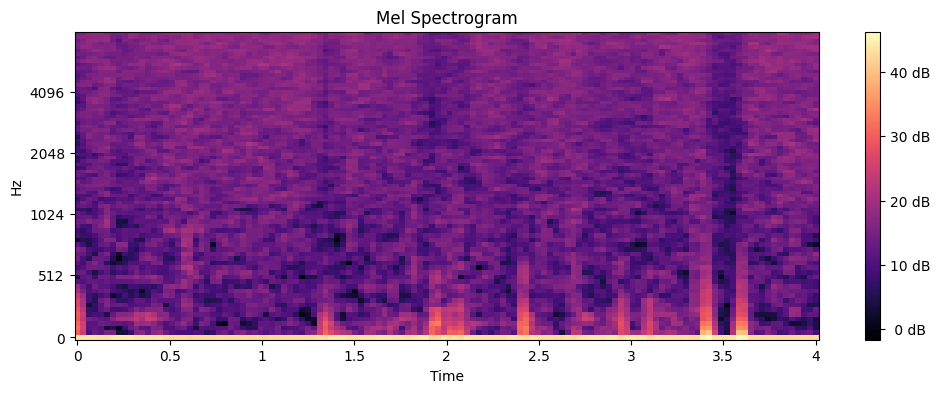

Reconstruction loss on waveform : 0.66
Reconstruction loss on spectogram : 4.41


In [3]:
# ==== Load Wavenet ==== 
# Initialize Wavenet and load weights
wavenet = WaveNet(
    out_channels=30, #
    layers=20, #
    stacks=2, #
    residual_channels=64, #
    gate_channels=128, # 
    skip_out_channels=64,  # 
    kernel_size=3,# 
    dropout=0.05, # 
    cin_channels=128,  
    scalar_input=True,
    upsample_conditional_features =True,
    upsample_scales=[4,4,4,1]
).to(device)
wavenet.load_state_dict(torch.load(WEIGHTS_WAVENET,weights_only=True))
wavenet.eval()  

# === Use latent of VQ-VAE as conditioning === 
z_e = vqvae.encode(wf_n)
with torch.no_grad():
    wf_wavenet = wavenet.incremental_forward(
        initial_input = None,
        c=z_e,
        T=32000,
        softmax=False,
        quantize=False
    ).squeeze(0).detach().cpu()

print(f"Reconstructed waveform shape : {wf_wavenet.shape}, sample rate {sr}")
visualize_waveform(wf_wavenet,sr=sr)
visualize_spectogram(torchaudio.transforms.AmplitudeToDB()(mel_transform(wf_wavenet)),sr=sr)
display(Audio(wf_wavenet,rate=sr))

# === Compute Loss between original and reconstruction === 
l1_loss = nn.L1Loss()
wavenet_l1 = l1_loss(wf_wavenet,display_wf)
wavenet_stft = stft_loss(wf_wavenet,display_wf)
print(f"Reconstruction loss on waveform : {wavenet_l1:.2f}")
print(f"Reconstruction loss on spectogram : {wavenet_stft:.2f}")